In [1]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from PIL import Image

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [3]:
cells=np.load('Cells.npy')
labels=np.load('Labels.npy')

In [4]:
print(cells[0])
print(labels[0])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
1


In [4]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [5]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [6]:
train_x.shape

(22046, 50, 50, 3)

In [7]:
img_rows=50
img_cols=50
num_classes=2
epochs = 10
batch_size = 128

In [8]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [9]:
eval_x.shape

(2756, 50, 50, 3)

In [10]:
test_y1=test_y
test_y1

array([0, 1, 1, ..., 1, 0, 0])

In [11]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [12]:
num_classes=len(np.unique(labels))
num_classes

2

In [13]:
vgg_conv=VGG16(include_top=False,weights='imagenet',input_shape=(img_rows, img_cols, 3))
print(vgg_conv.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [14]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
#Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000208B940A7F0> False
<keras.layers.convolutional.Conv2D object at 0x00000208B940ABE0> False
<keras.layers.convolutional.Conv2D object at 0x00000208B940A550> False
<keras.layers.pooling.MaxPooling2D object at 0x00000208B94C80F0> False
<keras.layers.convolutional.Conv2D object at 0x00000208B997AD30> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4B24240> False
<keras.layers.pooling.MaxPooling2D object at 0x00000208C4B33FD0> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4B56748> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4B56F98> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4B7F5C0> False
<keras.layers.pooling.MaxPooling2D object at 0x00000208C4B93DD8> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4BB2860> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4BCAD68> False
<keras.layers.convolutional.Conv2D object at 0x00000208C4BDBD30> False
<keras.

In [15]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model

### trying with bottleneck features

In [16]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten(input_shape=train_x.shape[1:]))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 14,766,190
Trainable params: 7,130,926
Non-trainable params: 7,635,264
_________________________________________________________________


In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 20s 909us/step - loss: 0.4040 - acc: 0.8690 - val_loss: 0.1819 - val_acc: 0.9314
Epoch 2/10
22046/22046 [==============================] - 17s 780us/step - loss: 0.2057 - acc: 0.9277 - val_loss: 0.1620 - val_acc: 0.9380
Epoch 3/10
22046/22046 [==============================] - 17s 763us/step - loss: 0.1624 - acc: 0.9450 - val_loss: 0.1866 - val_acc: 0.9372
Epoch 4/10
22046/22046 [==============================] - 17s 778us/step - loss: 0.1423 - acc: 0.9513 - val_loss: 0.1550 - val_acc: 0.9459
Epoch 5/10
22046/22046 [==============================] - 17s 754us/step - loss: 0.1171 - acc: 0.9582 - val_loss: 0.1306 - val_acc: 0.9496
Epoch 6/10
22046/22046 [==============================] - 16s 732us/step - loss: 0.1182 - acc: 0.9558 - val_loss: 0.1542 - val_acc: 0.9441
Epoch 7/10
22046/22046 [==============================] - 16s 744us/step - loss: 0.0987 - acc: 0.9635 - val_loss: 0.1

In [18]:
# Save the model
model.save('vgg.h5')

In [19]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

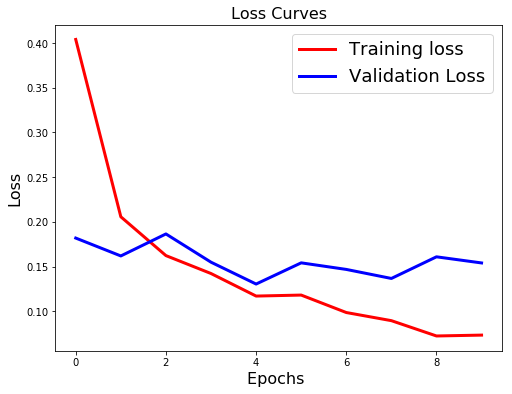

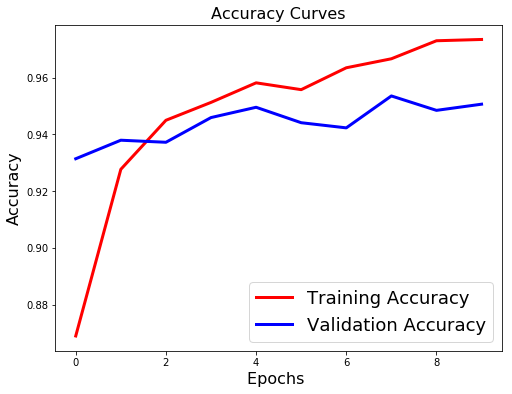

In [20]:
plot_loss_acc_curves(history)

In [21]:
classes=model.predict(test_x,batch_size=128)

In [22]:

classes


array([[9.9866712e-01, 1.3329078e-03],
       [3.8958162e-19, 1.0000000e+00],
       [1.5898563e-12, 1.0000000e+00],
       ...,
       [7.3410606e-04, 9.9926585e-01],
       [9.9964213e-01, 3.5783742e-04],
       [9.9996281e-01, 3.7206217e-05]], dtype=float32)

In [23]:
y_classes = classes.argmax(axis=-1)
y_classes

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

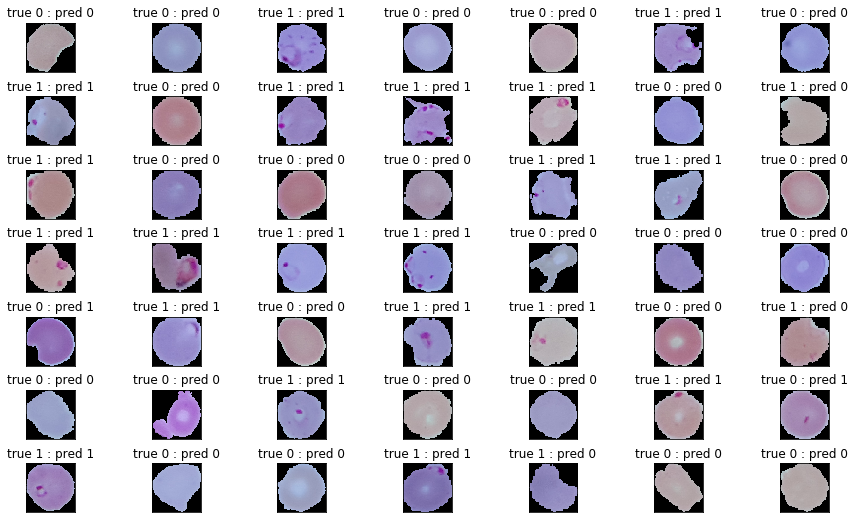

In [24]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , y_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [26]:
from sklearn.metrics import confusion_matrix,classification_report

In [28]:
# confusion matrix
print("Confusin Matrix : ")
print(confusion_matrix(test_y1, y_classes))
print('.'*100)

# classification report
print("Classification Report : ")
print(classification_report(test_y1, y_classes))

Confusin Matrix : 
[[1317   71]
 [  55 1313]]
....................................................................................................
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1388
           1       0.95      0.96      0.95      1368

   micro avg       0.95      0.95      0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756

